In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.stats import entropy
from helpers import style

from tqdm import tqdm
from collections import Counter
import networkx as nx

from scipy.spatial.distance import jensenshannon
from novelty.linkage import mutual_information

lda_path = '/home/rb/Documents/Data/models/lda/postwar-v3/'

style.load_style()

In [2]:
metadata = pd.read_csv('/home/rb/Documents/Data/metadata/metadata-full.tsv',sep='\t',usecols=['topic_id','session_type'])
plenary_filter = dict(zip(metadata.topic_id,metadata.session_type))

keys =  pd.read_csv(lda_path + 'keys.tsv', header=None, sep='\t',names=['ix','size','words','label'])
keys = dict(zip(keys.ix, keys.label))
keys_ = {v:k for k,v in keys.items()}

dat = pd.read_csv(lda_path + 'data.tsv',header=0,sep='\t',usecols=['topic_id','member-ref','party-ref','role','date','speaker','lemm_cleaned'],parse_dates=['date'])
dists = pd.read_csv(lda_path + 'dist.tsv', header=None, sep='\t').iloc[:, 2:].rename(columns=lambda x: x - 2)

In [3]:
dat_ = dat.copy()
dists_ = dists.copy()

dists_.index = dat_[['topic_id','member-ref']].astype(str).agg('_'.join,axis=1)
dists_ = dists_[dists_.index.str.split('_').str[0].map(plenary_filter) == 'plenary']

dists_ = dists_[[k for k,v in keys.items() if 'rhet' not in v and 'nonse' not in v and 'proc' not in v]]
dists_ = dists_.div(dists_.sum(axis=1), axis=0)

coltrans = {c:keys[cc] for c,cc in enumerate(dists_.columns)}
coltrans_ = {v:k for k,v in coltrans.items()}

In [5]:
new_index_date_mapping = dict(zip(dat_[['topic_id','member-ref']].astype(str).agg('_'.join,axis=1),dat_.date.apply(lambda d: pd.Timestamp(year = d.year, month = 1 if d.month < 7 else 6, day = 1))))

In [6]:
dz = dists_.apply(zscore,axis=0)
dists_ = dists_.where(dz >= 0, 0.0000000000001)
dists_ = dists_.div(dists_.sum(axis=1), axis=0)

In [173]:
r = []

for py, t in tqdm(dists_.groupby(dists_.index.str.split('.').str[4].str[:8])):
    topic_z_mean = dz[dz.index.str.contains(py)].mean()
    topic_sel = topic_z_mean[topic_z_mean > 0].index.map(keys).tolist()
    rij, ri, m = mutual_information_smooth(t.to_numpy())
    edf = pd.DataFrame(rij).stack().reset_index()
    edf.columns = ['s','t','pmi']
    edf['s'] = edf.s.map(coltrans)
    edf['t'] = edf.t.map(coltrans)
    edf = edf[(edf.pmi > 0) & (edf.s != edf.t)]
    edf = edf[(edf.s.isin(topic_sel)) & (edf.t.isin(topic_sel))]
    G = nx.from_pandas_edgelist(df = edf, source = 's', target = 't', edge_attr='pmi')
    communities = list(nx.algorithms.community.louvain.louvain_communities(G))
    r.append({
                "py":py,
                "mod":nx.algorithms.community.quality.modularity(G,communities),
                "degree":G.degree()
            }) 

  0%|          | 0/59 [00:00<?, ?it/s]

<AxesSubplot: xlabel='py'>

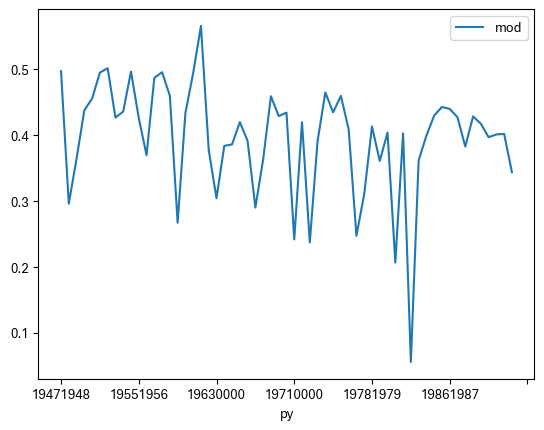

In [175]:
pd.DataFrame(r).plot(x='py',y='mod')

In [8]:
t = dists_[dists_.index.str.contains('19921993')]
topic_z_mean = dz[dz.index.str.split('.').str[4].str[:8] == '19921993'].mean()
topic_sel = topic_z_mean[topic_z_mean > 0].index.map(keys).tolist()

In [9]:
rij, ri, m = mutual_information_smooth(t.to_numpy())
edf = pd.DataFrame(rij).stack().reset_index()
edf.columns = ['s','t','pmi']
edf['s'] = edf.s.map(coltrans)
edf['t'] = edf.t.map(coltrans)
edf = edf[(edf.pmi > 0) & (edf.s != edf.t)]
edf = edf[(edf.s.isin(topic_sel)) & (edf.t.isin(topic_sel))]

In [10]:
G = nx.from_pandas_edgelist(df = edf, source = 's', target = 't', edge_attr='pmi')
pos = nx.spring_layout(G,k=.55,scale=1.25,iterations=10000,weight='pmi')
communities = list(nx.algorithms.community.louvain.louvain_communities(G))

num_communities = len(communities)
color_map = sns.color_palette('Set2', num_communities)

node_colors = {}
for node in G.nodes():
    for i, community in enumerate(communities):
        if node in community:
            node_colors[node] = color_map[i]
            break
deg = dict(G.degree())
locs = dict(pos)

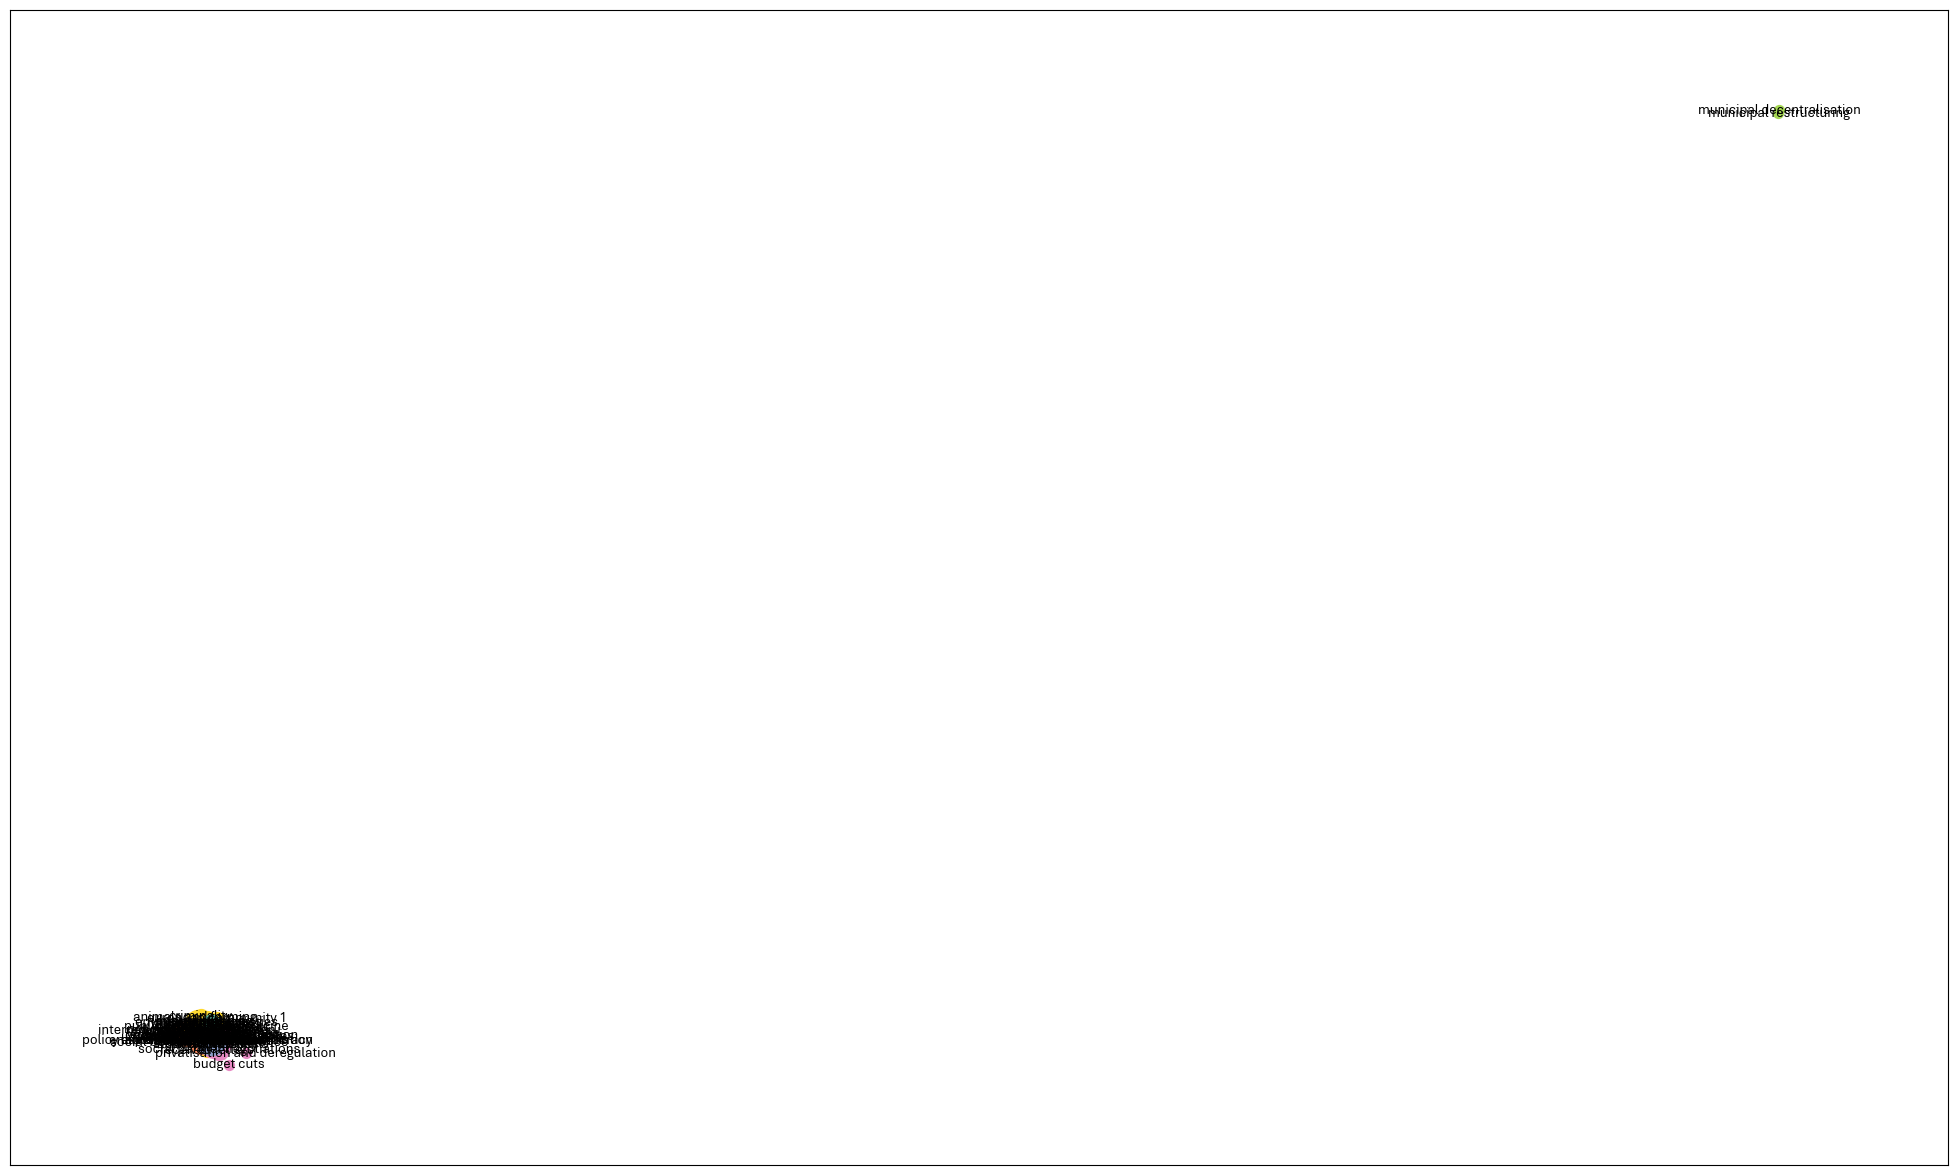

In [11]:

# Draw the graph with colored nodes and edges
f, a = plt.subplots(figsize=(25, 15))

nx.draw_networkx_edges(G,pos,alpha=0)

for node, (x,y) in pos.items():
    a.scatter([x],[y],s=deg[node] * 50, color=node_colors[node])
    a.annotate(text=node,xy=(x,y),color='black',ha='center',va='center')

for s, t in G.edges():
    sx,sy = locs[s]
    tx,ty = locs[t]
    a.plot([sx,tx],[sy,ty],color=node_colors[s],alpha=.25,lw=1,zorder=-1)

## Member

In [65]:
metadata = pd.read_csv('/home/rb/Documents/Data/metadata/metadata-full.tsv',sep='\t')
metadata = {m:f"{s}-{p}" for m,s,p in zip(metadata['member-ref'],metadata['speaker'],metadata['party-ref'])}

In [66]:
t = dists_[(dists_.index.str.contains('19821983'))]
tmz = t.groupby(t.index.str.split('_').str[1]).mean().apply(zscore,axis=0)

res = []
for m,tt in t.groupby(t.index.str.split('_').str[1]):
    ts = tmz.loc[m]
    ts.index  = ts.index.map(coltrans)
    ts = ts[ts > 0].index.tolist()
    rij, ri, mv = mutual_information_smooth(tt.to_numpy())
    edf = pd.DataFrame(rij).stack().reset_index()
    edf.columns = ['s','t','pmi']
    edf['s'] = edf.s.map(coltrans)
    edf['t'] = edf.t.map(coltrans)
    edf = edf[(edf.pmi > 0) & (edf.s != edf.t)]
    edf = edf[(edf.s.isin(ts)) & (edf.t.isin(ts))]
    edf['mb'] = metadata.get(m)
    res.append(edf)

In [67]:
res = pd.concat(res)

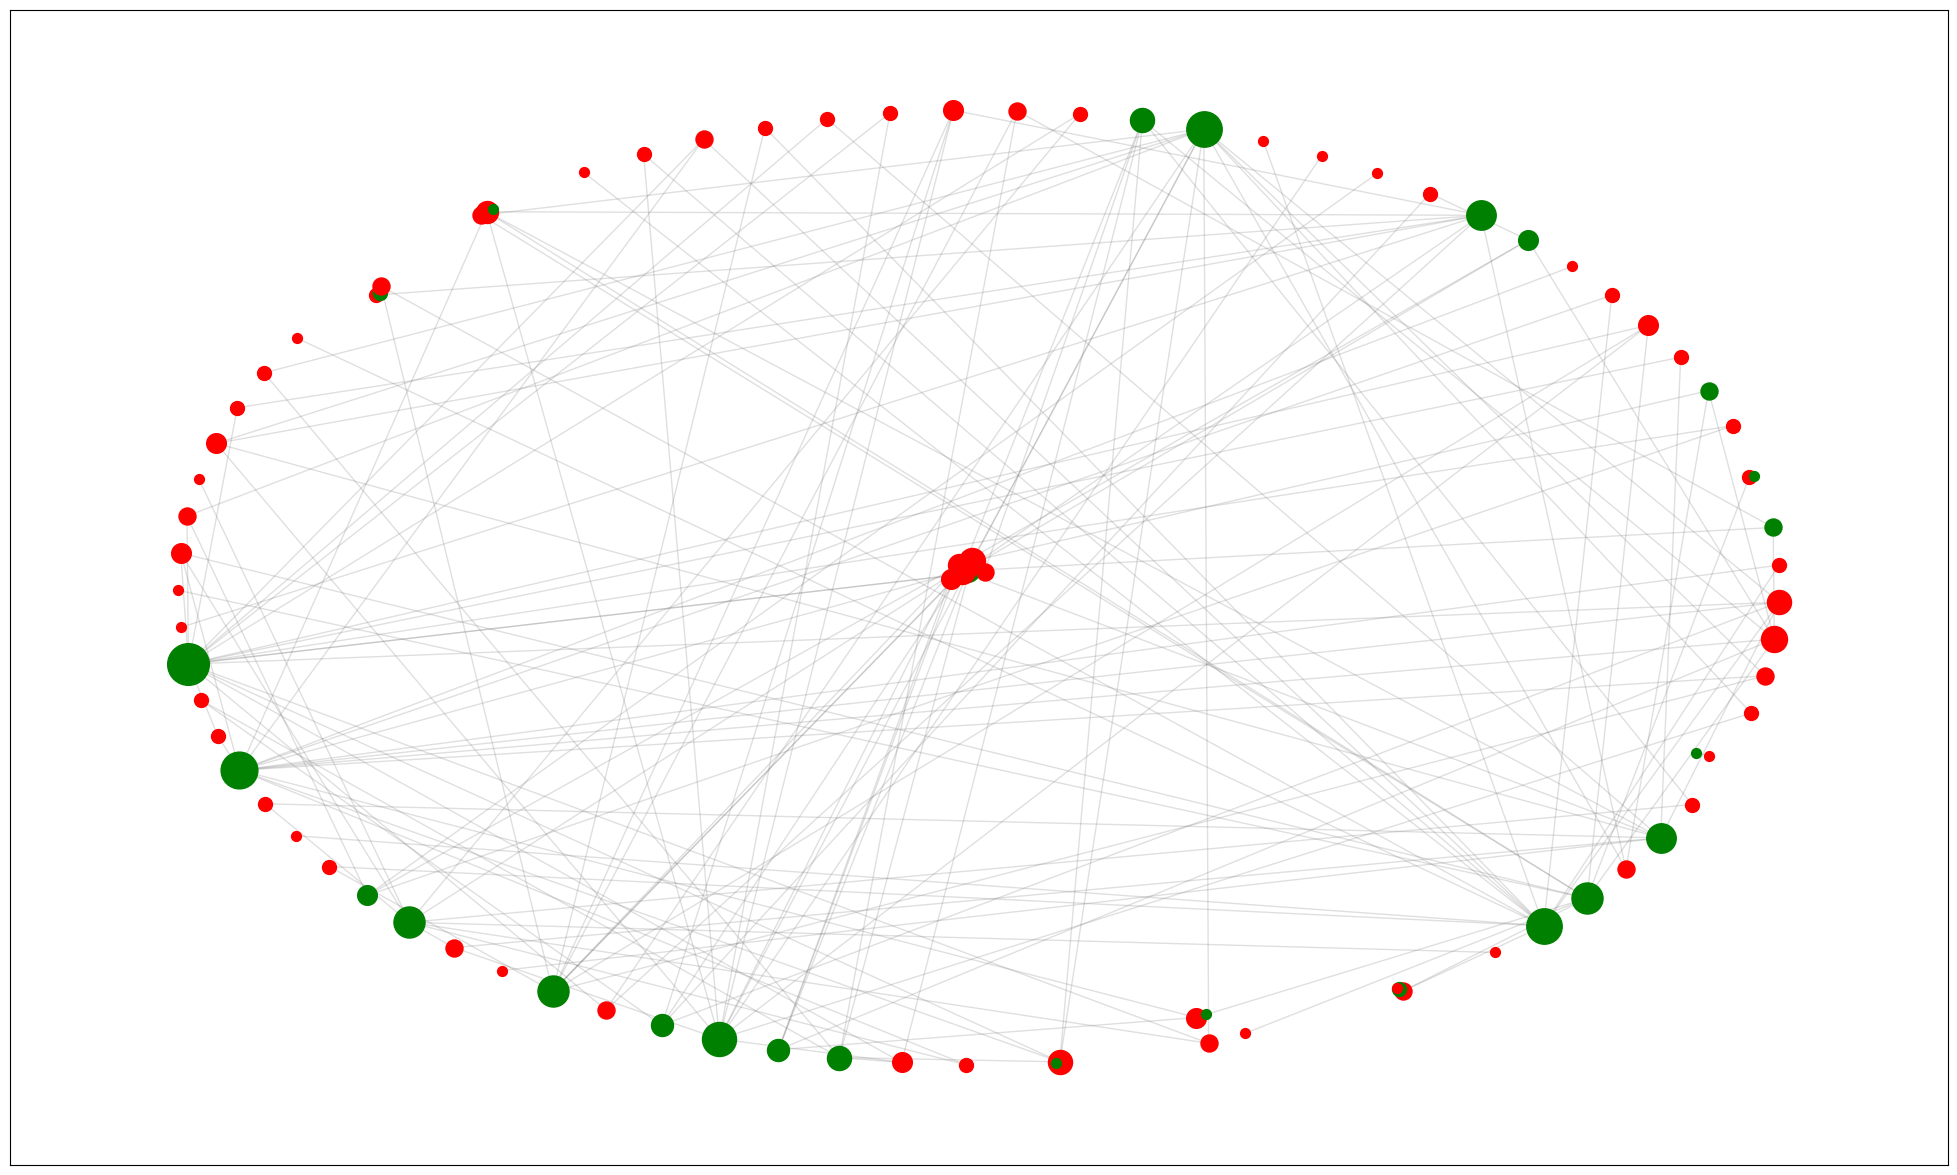

In [111]:
tt = res[(res.s.str.contains('nuclear'))]
G = nx.from_pandas_edgelist(df = tt, source = 't', target = 'mb', edge_attr='pmi')
pos = nx.spring_layout(G,k=.55,scale=1.25,iterations=10000,weight='pmi')


deg = dict(G.degree())
locs = dict(pos)


# Draw the graph with colored nodes and edges
f, a = plt.subplots(figsize=(25, 15))

nx.draw_networkx_edges(G,pos,alpha=0)

for node, (x,y) in pos.items():
    a.scatter([x],[y],s=deg[node] * 50, color='green' if 'nl.' in node else 'red')
    # a.annotate(text=node,xy=(x,y),color='black',ha='center',va='center')

for s, t in G.edges():
    sx,sy = locs[s]
    tx,ty = locs[t]
    a.plot([sx,tx],[sy,ty],color='grey',alpha=.25,lw=1,zorder=-1)

<AxesSubplot: xlabel='t', ylabel='mb'>

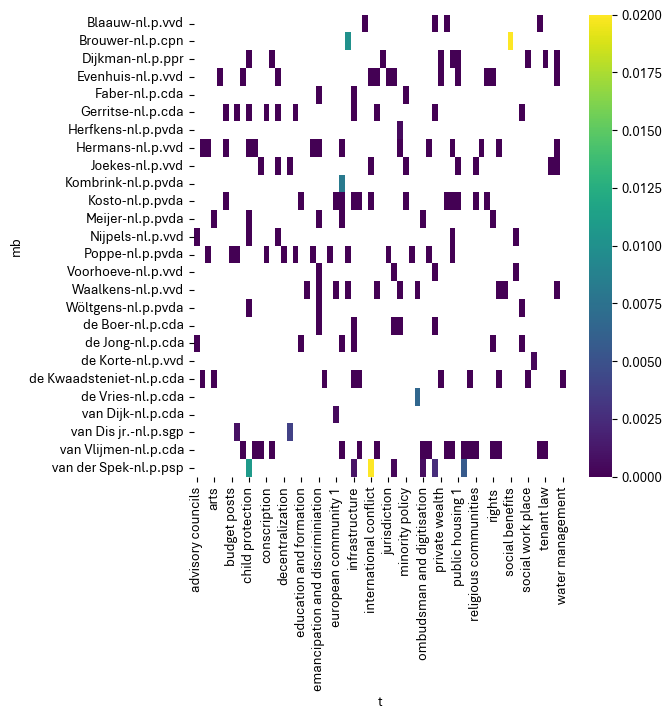

In [112]:
f,a = plt.subplots(figsize=(6,6))
sns.heatmap(tt.pivot(index='mb',columns='t',values='pmi'),vmax=.02,cmap='viridis')

In [113]:
tt.groupby('t').pmi.mean().sort_values()

t
budget posts                  3.428864e-40
decentralization              3.428864e-40
environmental policy          3.428864e-40
municipal decentralisation    3.428864e-40
education and formation       2.989786e-39
                                  ...     
received letters              2.777371e-03
norms and criterions          3.294823e-03
inflation                     3.356714e-03
international conflict        1.125420e-02
social benefits               5.180747e-02
Name: pmi, Length: 64, dtype: float64

In [17]:
metadata = pd.read_csv('/home/rb/Documents/Data/metadata/metadata-full.tsv',sep='\t')

metadata[metadata['member-ref'] == 'nl.m.02736']

,member-ref,speech_id,party-ref,role,speaker,topic_id,date,session_type,text_len
101853,nl.m.02676,nl.proc.sgd.d.199219930000823.3.5.6,nl.p.gpv,mp,Schutte,nl.proc.sgd.d.199219930000823.3,1992-11-12,plenary,73.0
101855,nl.m.02676,nl.proc.sgd.d.199219930000823.3.5.8,nl.p.gpv,mp,Schutte,nl.proc.sgd.d.199219930000823.3,1992-11-12,plenary,48.0
101857,nl.m.02676,nl.proc.sgd.d.199219930000823.3.5.10,nl.p.gpv,mp,Schutte,nl.proc.sgd.d.199219930000823.3,1992-11-12,plenary,77.0
101859,nl.m.02676,nl.proc.sgd.d.199219930000823.3.5.12,nl.p.gpv,mp,Schutte,nl.proc.sgd.d.199219930000823.3,1992-11-12,plenary,25.0
101861,nl.m.02676,nl.proc.sgd.d.199219930000823.3.5.14,nl.p.gpv,mp,Schutte,nl.proc.sgd.d.199219930000823.3,1992-11-12,plenary,29.0
...,...,...,...,...,...,...,...,...,...
1191877,nl.m.02676,nl.proc.sgd.d.198519860000847.3.2.78,nl.p.gpv,mp,Schutte,nl.proc.sgd.d.198519860000847.3,1986-08-01,plenary,68.0
1191910,nl.m.02676,nl.proc.sgd.d.198519860000847.3.9.1,nl.p.gpv,mp,Schutte,nl.proc.sgd.d.198519860000847.3,1986-08-01,plenary,4478.0
1192105,nl.m.02676,nl.proc.sgd.d.198519860000827.7.3.1,nl.p.gpv,mp,Schutte,nl.proc.sgd.d.198519860000827.7,1986-04-15,plenary,5045.0
1192365,nl.m.02676,nl.proc.sgd.d.198519860000780.4.3.34,nl.p.gpv,mp,Schutte,nl.proc.sgd.d.198519860000780.4,1985-11-07,plenary,76.0


In [87]:
metadata[metadata['member-ref'] == 'nl.m.00715']

,member-ref,speech_id,party-ref,role,speaker,topic_id,date,session_type,text_len
15896,nl.m.00715,nl.proc.sgd.d.195819590001223.3.23,nl.p.sgp,mp,Kodde,nl.proc.sgd.d.195819590001223.3,1958-11-20,plenary,2571.0
16113,nl.m.00715,nl.proc.sgd.d.195819590000715.2.10,nl.p.sgp,mp,Kodde,nl.proc.sgd.d.195819590000715.2,1958-11-05,plenary,1811.0
16139,nl.m.00715,nl.proc.sgd.d.195819590001208.2.20,nl.p.sgp,mp,Kodde,nl.proc.sgd.d.195819590001208.2,1958-10-14,plenary,1148.0
16321,nl.m.00715,nl.proc.sgd.d.195819590001224.3.17,nl.p.sgp,mp,Kodde,nl.proc.sgd.d.195819590001224.3,1958-11-25,plenary,684.0
16323,nl.m.00715,nl.proc.sgd.d.195819590001224.3.19,nl.p.sgp,mp,Kodde,nl.proc.sgd.d.195819590001224.3,1958-11-25,plenary,356.0
...,...,...,...,...,...,...,...,...,...
1201032,nl.m.00715,nl.proc.sgd.d.196019610002207.4.41,nl.p.sgp,mp,Kodde,nl.proc.sgd.d.196019610002207.4,1961-05-31,plenary,669.0
1201118,nl.m.00715,nl.proc.sgd.d.196019610001098.3.75,nl.p.sgp,mp,Kodde,nl.proc.sgd.d.196019610001098.3,1960-11-24,plenary,68.0
1201120,nl.m.00715,nl.proc.sgd.d.196019610001098.3.77,nl.p.sgp,mp,Kodde,nl.proc.sgd.d.196019610001098.3,1960-11-24,plenary,126.0
1201122,nl.m.00715,nl.proc.sgd.d.196019610001098.3.79,nl.p.sgp,mp,Kodde,nl.proc.sgd.d.196019610001098.3,1960-11-24,plenary,23.0


In [80]:
ixm = t.idxmax(axis=1)

In [86]:
ixm[ixm == keys_['damage and restitutions']]

nl.proc.sgd.d.195919600000194.2_nl.m.01122    179
nl.proc.sgd.d.195919600000194.2_nl.m.01594    179
nl.proc.sgd.d.195919600000196.3_nl.m.00060    179
nl.proc.sgd.d.195919600000196.3_nl.m.01417    179
nl.proc.sgd.d.195919600000199.2_nl.m.00786    179
                                             ... 
nl.proc.sgd.d.195919600002144.7_nl.m.00715    179
nl.proc.sgd.d.195919600002144.7_nl.m.00715    179
nl.proc.sgd.d.195919600002144.7_nl.m.00715    179
nl.proc.sgd.d.195919600002144.7_nl.m.00715    179
nl.proc.sgd.d.195919600002144.7_nl.m.00715    179
Length: 94, dtype: int64